In [1]:
import torch
import os
import torch.nn.init as init
from torchvision import datasets, transforms
from torch import optim, nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import logging
import math
import copy
import torch.nn.functional as F

/Users/dongpochen/opt/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = './output'

## Dataloader

In [3]:
tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

In [4]:
def task_dataloader(task_num):
    task_dir = {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7], 4:[8, 9]}

    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=tf)

    indices = [i for i, (_, label) in enumerate(train_dataset) if label in task_dir[task_num]]
    dataset = Subset(train_dataset, indices)
    task_train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    indices = [i for i, (_, label) in enumerate(test_dataset) if label in task_dir[task_num]]
    dataset = Subset(test_dataset, indices)
    task_test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return task_train_loader, task_test_loader

def load_all_data():
    train_dataset = datasets.MNIST(root='./data', train=True, transform=tf, download=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader

In [5]:
def adjust_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.75 * param_group['lr']

## Model

### Meta Model

In [6]:
from torch.autograd import Function

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [7]:
class DeepModelWithAttention(nn.Module):
    def __init__(self, desired_sum):
        super(DeepModelWithAttention, self).__init__()
        self.desired_sum = desired_sum

        self.attn = nn.MultiheadAttention(embed_dim=2, num_heads= 1)
        self.fc = nn.Linear(2, 1)
        
    def forward(self, x, mode = "eval"):
        if mode == "train":
            x = ReverseLayerF.apply(x, 1)

        attn_output, _ = self.attn(x, x, x)
        attn_output = attn_output.mean(dim = 1)
        output = self.fc(attn_output).squeeze(-1) 
        
        output = F.softmax(output, dim = 0) * self.desired_sum

        return output

### MLP 400

In [8]:
class MLP_Enhance(nn.Module):
    def __init__(self, out_dim=10, in_channel=1, img_sz=28, hidden_dim=400):
        super(MLP_Enhance, self).__init__()
        self.in_dim = in_channel*img_sz*img_sz
        self.linear = nn.Sequential(
            nn.Linear(self.in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
        )
        self.last = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax(dim=1)
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                init.constant_(layer.bias, 0)
        last_linear = self.last[0]
        init.xavier_normal_(last_linear.weight)
        init.constant_(last_linear.bias, 0)


    def features(self, x):
        x = self.linear(x.view(-1,self.in_dim))
        return x

    def logits(self, x):
        x = self.last(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x

In [9]:
train_loader, test_loader = load_all_data()
task_dataloaders = {}
for task in range(0, 5):
    train_dl, test_ld = task_dataloader(task)
    task_dataloaders[task] = (train_dl, test_ld)

In [10]:
def cal_acc(model, dataloader, device):
    model.eval()
    correct, total = 0., 0.
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [11]:
def plot_acc_history(all_accuracies):
    plt.figure(figsize=(18, 12))

    for i, task_accuracies in enumerate(all_accuracies):
        plt.subplot(2, 3, i+1)
        for task, accs in task_accuracies.items():
            plt.plot(accs,'-', label=f'Task {task}')
        plt.title(f'Accuracy per Mini-Batch for Task {i}')
        plt.xlabel('Mini-Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(-5, 105)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_task_acc_history(all_accuracies, save_name, epochs):
    for task in [0, 1, 2, 3, 4]:
        if (task == 0):
            task_history = []
        else:
            task_history =  [0] * (epochs * 98 * task)
        for i, task_accuracies in enumerate (all_accuracies):
            if (i >= task):
                task_history.extend(task_accuracies[task])
                    
        plt.plot(task_history, '-', label=f'Task {task}')

    plt.xlabel('Mini-Batch Number')
    plt.ylabel('Accuracy (%)')
    plt.ylim(-5, 105)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_name) 
    plt.show()

# Train

In [12]:
def pretrain_meta(meta_model, optimizer_M, task_num):
    target = torch.full((task_num, 1, 1), 2.0).to(device)
    criterion = nn.MSELoss()

    print("Pretrain on meta_model")
    for epoch in range(400):
        prev_outputs = None
        for k in range (task_num):
            past_output = F.softmax(torch.rand(batch_size, 10), dim=-1).to(device)
            outputs = F.softmax(torch.rand(batch_size, 10), dim=-1).to(device)
            diff = past_output[:,k*2:k * 2 + 2] - outputs[:,k*2:k * 2 + 2]
            diff = diff.unsqueeze(0)
            if (prev_outputs == None):
                prev_outputs = diff
            else:
                prev_outputs = torch.cat((prev_outputs, diff), dim=0)

        meta_out = meta_model(prev_outputs).view(-1, 1, 1 )

        meta_model.train()
        optimizer_M.zero_grad()
        loss = criterion(meta_out, target)
        loss.backward()
        optimizer_M.step()

In [13]:
def diff_loss(model, criterion, distribution_factor):
    random_data = torch.rand(256, 1, 28, 28).to(device)
    random_data = (random_data - 0.5) / 0.5
    random_target = torch.randint(0, 10, (256,), dtype=torch.int64).to(device)
    fake_output = model(random_data)
    d_loss = distribution_factor * criterion(fake_output, random_target)
    return d_loss

def reg_loss(outputs, meta_model, images, prev_model, mode = "eval"):
    prev_outputs = None
    for k, prev_mod in enumerate(prev_model):
        with torch.no_grad():
            past_output = prev_mod(images)
        diff = torch.abs(past_output[:,k*2:k * 2 + 2] - outputs[:,k*2:k * 2 + 2])
        diff = diff.unsqueeze(0)
        if (prev_outputs == None):
            prev_outputs = diff
        else:
            prev_outputs = torch.cat((prev_outputs, diff), dim=0)

    mean_diff = torch.mean(prev_outputs, dim = (1, 2))

    if (mode == "eval"):
        with torch.no_grad():
            meta_out = meta_model(prev_outputs)
    else:
        meta_out = meta_model(prev_outputs, mode = mode)

    reg_loss = torch.sum(meta_out * mean_diff)

    return reg_loss
    

def train(model, task_num, optimizer_F, criterion, prev_model, epoches = 4, verbose = 0):
    train_loader = task_dataloaders[task_num][0]
    task_accuracies = {task: [] for task in range(task_num + 1)}

    distribution_factor = 15

    if (task_num != 0):
        meta_model = DeepModelWithAttention(desired_sum = 2 * task_num).to(device)
        optimizer_M = optim.Adam(meta_model.parameters(), lr=0.001)
        pretrain_meta(meta_model, optimizer_M, task_num)
    
    valid_out_dim = task_num * 2 + 2
    logging.info(f"##########Task {task_num}##########")
    for e in range(epoches):
        logging.info(f"Epoch {e}")
        batch_num = 0
        for images, labels in train_loader:
            model.train()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            classifiaction_loss = criterion(outputs[:,:valid_out_dim], labels)

            d_loss = diff_loss(model, criterion, distribution_factor)
            if (task_num != 0):
                r_loss = reg_loss(outputs, meta_model, images, prev_model, mode = "eval")
            else:
                r_loss = 0
            
            loss = classifiaction_loss + r_loss + d_loss
            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            if (task_num!= 0):
                with torch.no_grad():
                    outputs = model(images)
                
                meta_loss = reg_loss(outputs, meta_model, images, prev_model, mode = "train")

                optimizer_M.zero_grad()
                meta_loss.backward()
                optimizer_M.step()

            batch_num += 1

            if (verbose == 1):
                avg_acc = 0
                log_message = []
                log_message.append(f"Batch num: {batch_num}, ")
                for task in range(task_num + 1):
                    acc = cal_acc(model, task_dataloaders[task][0], device)
                    avg_acc += acc
                    task_accuracies[task].append(acc * 100)
                    log_message.append(f"Task {task} acc: {acc * 100:.4f}")
                logging.info(', '.join(log_message) + f", Task avg acc:{avg_acc*100/(task_num + 1):.4f}")

        if (verbose == 0):
            avg_acc = 0
            log_message = []
            log_message.append(f"Epoch: {e}, ")
            for task in range(task_num + 1):
                acc = cal_acc(model, task_dataloaders[task][0], device)
                avg_acc += acc
                task_accuracies[task].append(acc * 100)
                log_message.append(f"Task {task} acc: {acc * 100:.4f}")

            logging.info(', '.join(log_message) + f"Task avg acc:{avg_acc*100/(task_num + 1):.4f}")
            if(task_num != 0):
                logging.info(f'loss:{loss.item()}, c_loss: {classifiaction_loss: .4f}, reg_loss:{r_loss:.4f}')
    
    return task_accuracies

In [14]:
def setup_logging(file_name):
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        handlers=[
                            logging.FileHandler(file_name),
                            logging.StreamHandler()
                        ],
                        force=True)
    
def train_split_task(task_name):
    print(f"Training on {task_name}")
    prev_model = []
    model = MLP_Enhance()
    model = model.to(device)
    optimizer_F = torch.optim.Adam(model.parameters(), 0.005)
    criterion = nn.CrossEntropyLoss()

    epochs, lr = 4, 0.005

    file_name = f"{output_dir}/{task_name}_epochs={epochs}"

    log_file_name = file_name + '.log'
    img_file_name = file_name + '.png'
    if True:
    # if os.path.exists(log_file_name) == False:
        setup_logging(log_file_name)
        all_accuracies = []
        for task in [0, 1, 2, 3, 4]:
            task_accuracies = train(model, task, optimizer_F, criterion, prev_model, epoches = epochs, verbose = 1)
            all_accuracies.append(task_accuracies)
            prev_model.append(copy.deepcopy(model))

        plot_task_acc_history(all_accuracies, img_file_name, epochs)

2024-06-02 12:22:09,230 - INFO - ##########Task 0##########
2024-06-02 12:22:09,231 - INFO - Epoch 0


Training on test


2024-06-02 12:22:10,360 - INFO - Batch num: 1, , Task 0 acc: 45.6792, Task avg acc:45.6792
2024-06-02 12:22:11,267 - INFO - Batch num: 2, , Task 0 acc: 46.8351, Task avg acc:46.8351
2024-06-02 12:22:12,172 - INFO - Batch num: 3, , Task 0 acc: 77.1684, Task avg acc:77.1684
2024-06-02 12:22:13,074 - INFO - Batch num: 4, , Task 0 acc: 84.0960, Task avg acc:84.0960
2024-06-02 12:22:13,979 - INFO - Batch num: 5, , Task 0 acc: 86.4318, Task avg acc:86.4318
2024-06-02 12:22:14,920 - INFO - Batch num: 6, , Task 0 acc: 85.2041, Task avg acc:85.2041
2024-06-02 12:22:15,849 - INFO - Batch num: 7, , Task 0 acc: 85.1642, Task avg acc:85.1642
2024-06-02 12:22:16,771 - INFO - Batch num: 8, , Task 0 acc: 84.3909, Task avg acc:84.3909
2024-06-02 12:22:17,683 - INFO - Batch num: 9, , Task 0 acc: 83.8648, Task avg acc:83.8648
2024-06-02 12:22:18,601 - INFO - Batch num: 10, , Task 0 acc: 83.4503, Task avg acc:83.4503
2024-06-02 12:22:19,519 - INFO - Batch num: 11, , Task 0 acc: 83.3705, Task avg acc:83.37

Pretrain on meta_model


2024-06-02 12:28:57,368 - INFO - ##########Task 1##########
2024-06-02 12:28:57,368 - INFO - Epoch 0
2024-06-02 12:28:59,455 - INFO - Batch num: 1, , Task 0 acc: 97.9114, Task 1 acc: 3.6818, Task avg acc:50.7966
2024-06-02 12:29:01,507 - INFO - Batch num: 2, , Task 0 acc: 97.8316, Task 1 acc: 5.5269, Task avg acc:51.6793
2024-06-02 12:29:03,571 - INFO - Batch num: 3, , Task 0 acc: 97.6562, Task 1 acc: 8.3610, Task avg acc:53.0086
2024-06-02 12:29:05,711 - INFO - Batch num: 4, , Task 0 acc: 96.9069, Task 1 acc: 11.9681, Task avg acc:54.4375
2024-06-02 12:29:07,775 - INFO - Batch num: 5, , Task 0 acc: 91.1830, Task 1 acc: 16.2566, Task avg acc:53.7198
2024-06-02 12:29:09,825 - INFO - Batch num: 6, , Task 0 acc: 75.7573, Task 1 acc: 21.0938, Task avg acc:48.4255
2024-06-02 12:29:11,867 - INFO - Batch num: 7, , Task 0 acc: 62.2608, Task 1 acc: 25.2992, Task avg acc:43.7800
2024-06-02 12:29:13,892 - INFO - Batch num: 8, , Task 0 acc: 56.5609, Task 1 acc: 26.6872, Task avg acc:41.6240
2024-0

Pretrain on meta_model


2024-06-02 12:41:50,106 - INFO - ##########Task 2##########
2024-06-02 12:41:50,106 - INFO - Epoch 0
2024-06-02 12:41:53,164 - INFO - Batch num: 1, , Task 0 acc: 73.1027, Task 1 acc: 72.6978, Task 2 acc: 0.5478, Task avg acc:48.7828
2024-06-02 12:41:56,197 - INFO - Batch num: 2, , Task 0 acc: 73.9477, Task 1 acc: 71.9082, Task 2 acc: 0.6825, Task avg acc:48.8461
2024-06-02 12:41:59,208 - INFO - Batch num: 3, , Task 0 acc: 76.4509, Task 1 acc: 71.2018, Task 2 acc: 0.8980, Task avg acc:49.5169
2024-06-02 12:42:02,230 - INFO - Batch num: 4, , Task 0 acc: 78.4279, Task 1 acc: 70.1130, Task 2 acc: 1.0147, Task avg acc:49.8519
2024-06-02 12:42:05,275 - INFO - Batch num: 5, , Task 0 acc: 79.6237, Task 1 acc: 67.8939, Task 2 acc: 1.0237, Task avg acc:49.5138
2024-06-02 12:42:08,273 - INFO - Batch num: 6, , Task 0 acc: 79.4324, Task 1 acc: 66.1486, Task 2 acc: 1.2751, Task avg acc:48.9520
2024-06-02 12:42:11,273 - INFO - Batch num: 7, , Task 0 acc: 79.7911, Task 1 acc: 63.8630, Task 2 acc: 1.56

Pretrain on meta_model


2024-06-02 12:59:21,191 - INFO - ##########Task 3##########
2024-06-02 12:59:21,192 - INFO - Epoch 0
2024-06-02 12:59:25,272 - INFO - Batch num: 1, , Task 0 acc: 63.6798, Task 1 acc: 14.1041, Task 2 acc: 69.0374, Task 3 acc: 3.1332, Task avg acc:37.4886
2024-06-02 12:59:29,258 - INFO - Batch num: 2, , Task 0 acc: 63.9110, Task 1 acc: 14.3118, Task 2 acc: 67.9688, Task 3 acc: 3.6349, Task avg acc:37.4566
2024-06-02 12:59:33,222 - INFO - Batch num: 3, , Task 0 acc: 65.0191, Task 1 acc: 15.7829, Task 2 acc: 64.6462, Task 3 acc: 4.2681, Task avg acc:37.4291
2024-06-02 12:59:37,149 - INFO - Batch num: 4, , Task 0 acc: 65.7844, Task 1 acc: 18.5588, Task 2 acc: 60.7220, Task 3 acc: 4.3257, Task avg acc:37.3477
2024-06-02 12:59:41,212 - INFO - Batch num: 5, , Task 0 acc: 67.3709, Task 1 acc: 25.9807, Task 2 acc: 54.2654, Task 3 acc: 4.6135, Task avg acc:38.0576
2024-06-02 12:59:45,256 - INFO - Batch num: 6, , Task 0 acc: 69.5392, Task 1 acc: 35.2643, Task 2 acc: 45.9321, Task 3 acc: 5.2467, Ta

Pretrain on meta_model


2024-06-02 13:24:58,154 - INFO - ##########Task 4##########
2024-06-02 13:24:58,154 - INFO - Epoch 0
2024-06-02 13:25:03,239 - INFO - Batch num: 1, , Task 0 acc: 67.7854, Task 1 acc: 38.6636, Task 2 acc: 18.9565, Task 3 acc: 75.5510, Task 4 acc: 0.2632, Task avg acc:40.2439
2024-06-02 13:25:08,232 - INFO - Batch num: 2, , Task 0 acc: 69.3479, Task 1 acc: 41.0073, Task 2 acc: 19.5312, Task 3 acc: 70.7155, Task 4 acc: 0.3567, Task avg acc:40.1917
2024-06-02 13:25:13,376 - INFO - Batch num: 3, , Task 0 acc: 70.7669, Task 1 acc: 43.3511, Task 2 acc: 20.4113, Task 3 acc: 64.7944, Task 4 acc: 0.5010, Task avg acc:39.9649
2024-06-02 13:25:18,419 - INFO - Batch num: 4, , Task 0 acc: 73.1585, Task 1 acc: 46.5509, Task 2 acc: 21.9738, Task 3 acc: 58.9227, Task 4 acc: 0.7982, Task avg acc:40.2808
2024-06-02 13:25:23,467 - INFO - Batch num: 5, , Task 0 acc: 73.1744, Task 1 acc: 48.8780, Task 2 acc: 23.8236, Task 3 acc: 53.0921, Task 4 acc: 0.9341, Task avg acc:39.9805
2024-06-02 13:25:28,481 - INF

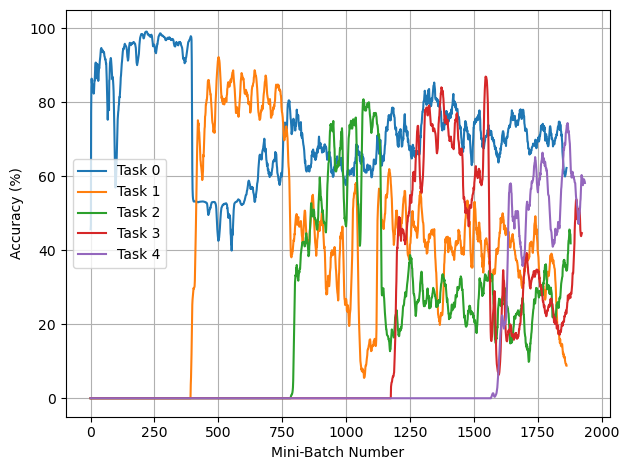

In [15]:
train_split_task("test")